# Autoencoders #

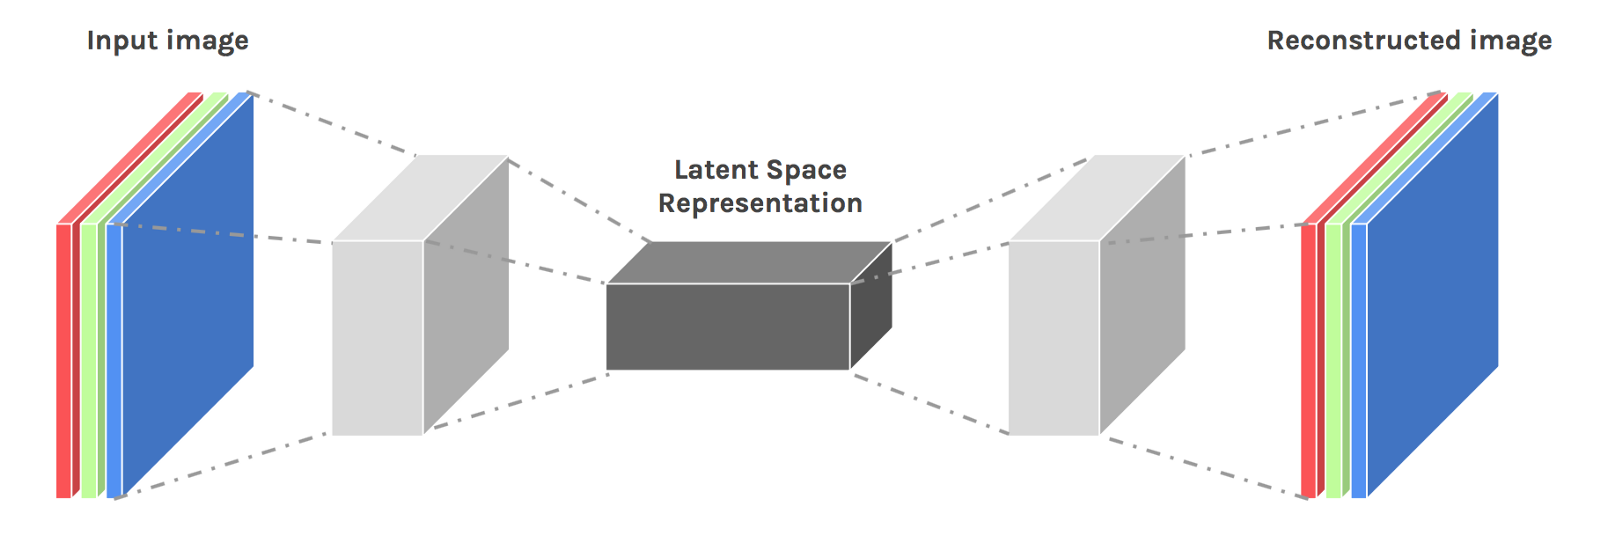

We will be working with the *Labeled Faces in the Wild* dataset in this class, you can find out more about the dataset on this link: http://vis-www.cs.umass.edu/lfw/ . 

As the first step, please, download and extract the dataset. The direct download link is: http://vis-www.cs.umass.edu/lfw/lfw.tgz .

The structure of the downloaded data is that the root directory contains directories named after the people and each subdirectory contains one or more images of that person.

In [6]:
# Import all the libraries
import os as os
import numpy as numpy
from scipy import ndimage
from six.moves import cPickle as pickle
import random as random
import itertools as itertools
import tensorflow as tf
import matplotlib.pyplot as plt
import math as math

** IMPORTANT **

Here set the directory where you have extracted the dataset. The `numFaces` variable gives you a number of people to read in. If you do not have GPU, 50 is reasonable option for the class.

In [7]:
basePath = "./lfw/"
numFaces = 50

In [8]:
# Load the images and store them if necessary.
def readSingleImage(fileName):
    return(ndimage.imread(fileName, mode="RGB"))

   
def loadPicturesFromFiles(basePath):
    allNames = os.listdir(basePath)[1:numFaces]
    allPictures = {}
    for personName in allNames:
        personPictureDirectory = os.path.join(basePath, personName)
        if (not (personName[0] == ".")) & os.path.isdir(personPictureDirectory):
            print("Reading faces of " + personName + "...", end="")
            pictureFiles = os.listdir(personPictureDirectory)
            pictureFiles = list(map(os.path.join, [personPictureDirectory] * len(pictureFiles), pictureFiles))
            pictures = list(map(readSingleImage, pictureFiles))
            print(" DONE (" + str(len(pictures)) + " read)")
            allPictures[personName] = pictures
    return(allPictures)

allImagesDict = loadPicturesFromFiles(basePath)
#pickle.dump(allImagesDict, open("./autoencoder images.pickle", "wb"))

FileNotFoundError: [Errno 2] No such file or directory: './lfw/'

In [ ]:
#allImages = pickle.load(open("./autoencoder images.pickle", "wb"))

Split loaded images into training and testing set in 3 to 1 ratio.

In [ ]:
def splitImagesToTrainingAndTestingSets(allImagesDict, trainingPortion = 0.75):
    trainingImages = []
    trainingLabels = []
    testingImages  = []
    testingLabels  = []
    for personNames, pictures in allImagesDict.items():
        if (random.uniform(0,1) < trainingPortion):
            trainingLabels.append([personNames] * len(pictures))
            trainingImages.append(pictures)
        else:
            testingLabels.append([personNames] * len(pictures))
            testingImages.append(pictures)
    return((
        list(itertools.chain(*trainingImages)),
        list(itertools.chain(*trainingLabels)),
        list(itertools.chain(*testingImages)),
        list(itertools.chain(*testingLabels))))

[originalTrainingImages, trainingLabels, originalTestingImages, testingLabels] = splitImagesToTrainingAndTestingSets(allImagesDict)

Images in the LWF dataset are 250x250 pixels. This limits the filters we may apply. To get more reasonable range we will extend the images to 256x256 pixels by adding black pixels to the right and bottom margins.

In [ ]:
def expandSingleImage(img):
    expandedImage = numpy.zeros((256, 256, 3), dtype=numpy.uint8)
    expandedImage[:img.shape[0], :img.shape[1], :] = img
    return(expandedImage)

def expandAllImages(trainingImages, testingImages):
    trainingImages = list(map(expandSingleImage, trainingImages))
    testingImages  = list(map(expandSingleImage, testingImages))
    return((trainingImages, testingImages))

[expandedTrainingImages, expandedTestingImages] = expandAllImages(originalTrainingImages, originalTestingImages)

# Show Loaded Images

Here you may display training and testing images you have loaded. Be careful, if you load a lot of images, consider limiting the number of images to display.

### Training Images

In [ ]:
numImageRows = 1 + (len(expandedTrainingImages) // 10)
plt.figure(figsize=(50, 5 * numImageRows))
for imgID in range(len(expandedTrainingImages)):
    plt.subplot(numImageRows, 10, imgID + 1)
    plt.imshow(expandedTrainingImages[imgID])
plt.show()

### Testing Images

In [ ]:
numImageRows = 1 + (len(expandedTestingImages) // 10)
plt.figure(figsize=(50, numImageRows * 5))
for imgID in range(len(expandedTestingImages)):
    plt.subplot(numImageRows, 10, imgID + 1)
    plt.imshow(expandedTestingImages[imgID])
plt.show()

### Scale Pixel Values

The pixel values in images are on scale between 0 and 255, but the autoencoders work better if the values are on 0 to 1 scale. Thus we scale the inputs and provide a function to scale back the images to 0 to 255 range to display network outputs.


In [ ]:
def zeroOneScaleColoursInImages(trainingImages, testingImages):
    trainingImages = list(map(lambda image: image / 255.0, trainingImages))
    testingImages  = list(map(lambda image: image / 255.0, testingImages))
    return((trainingImages, testingImages))

def backScaleColoursInImages(imageList):
    imageList = list(map(lambda image: image * 255, imageList))
    imageList = list(map(lambda image: image.astype(numpy.uint8), imageList))
    return(imageList)

[trainingImages, testingImages] = zeroOneScaleColoursInImages(expandedTrainingImages, expandedTestingImages)

# Simple Autoencoder

The first experiment will be testing very simple setup, just to demonstrate that it is actually working and we can experiment with the latent layer.

The training of the network takes reasonable time so you are encouraged to test different number of filters in the encoding layer (`codeLayer` variable). Also you can experiment with `kernel_size` and `stride` parameters. Don't forget to keep these in sync in encoding and decoding step.

The figure below gives the idea of the structure of the network.

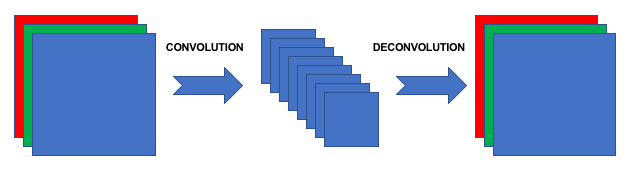

### Define Network and Training & Loss Function

In [ ]:
tf.reset_default_graph()
inputLayer    = tf.placeholder(tf.float32, (None, 256, 256, 3))
codeLayer = tf.contrib.layers.conv2d(inputs = inputLayer, num_outputs = 12, kernel_size = 3, stride = 2, padding = "SAME")
outputLayer   = tf.contrib.layers.conv2d_transpose(inputs = codeLayer, num_outputs = 3, kernel_size = 3, stride = 2, padding = "SAME")
print(inputLayer.shape)
print(codeLayer.shape)
print(outputLayer.shape)

In [ ]:
# calculate the loss and optimize the network
lossFunction = tf.reduce_mean(tf.square(outputLayer - inputLayer))  # calaculate the mean square error loss
optimisation = tf.train.AdamOptimizer().minimize(lossFunction)

# initialize the network
init = tf.global_variables_initializer()

In [ ]:
def showProgressOnTestingImages(inputTstImgs, outputTstImgs):
    
    inputTstImgs  = backScaleColoursInImages(inputTstImgs)
    outputTstImgs = backScaleColoursInImages(outputTstImgs)
        
    plt.figure(figsize=(7.5, 2.5 * len(inputTstImgs)))
    for imgID in range(len(inputTstImgs)):
        plt.subplot(len(inputTstImgs)+1, 3, imgID * 3 + 1)
        plt.imshow(inputTstImgs[imgID])

        plt.subplot(len(inputTstImgs)+1, 3, imgID * 3 + 3)
        plt.imshow(outputTstImgs[imgID])
    plt.show()

### Training of the Network

In [ ]:
session = tf.Session()
session.run(init)

#Evaluate test images on randomly initialised network
outputTstImgs = session.run([outputLayer], feed_dict={inputLayer: testingImages})
showProgressOnTestingImages(testingImages, outputTstImgs[0])

for epochID in range(101):
    epochTrainingImages = random.sample(trainingImages, len(trainingImages))
    batchLen = len(epochTrainingImages) // 10 # Be careful here if you have large number of images.
    print("Running epoch {}".format(epochID), end="")
    for batchID in range(batchLen):
        batchImages = epochTrainingImages[batchID * batchLen : min((batchID+1) * batchLen, len(epochTrainingImages))]
        if len(batchImages) == 0:
            continue
        _, trainLoss = session.run([optimisation, lossFunction], feed_dict = {inputLayer: batchImages})
        print(".", end="")
    testLoss = session.run([lossFunction], feed_dict = {inputLayer: testingImages})
    print(" loss on testing was {}".format(testLoss))
    if (epochID % 25 == 0):
        outputTstImgs = session.run([outputLayer], feed_dict={inputLayer: testingImages})
        showProgressOnTestingImages(testingImages, outputTstImgs[0])
        

# Compressing AutoEncoder

Now lets try more complex stuff. We will define the autoencoder that achieves much higher "compression ratio" and goes from 256x256 pixels and 3 colour panes to 16x16 values in latent representation and 5 filters. The general idea is the same as in previous case, only there are more convolution and deconvolution layers.

The training of this autoencoder takes more time, so you can try it at home. To demonstrate the abilities, we have pretrained the model for you. To read it, you need to execute the next two cells - to define the graph and then go to the last cell and execute it.

### Define Network and Loss Function

In [ ]:
tf.reset_default_graph()
inputLayer = tf.placeholder(tf.float32, (None, 256, 256, 3))
covLayer1 = tf.contrib.layers.conv2d(inputs = inputLayer,
                                     num_outputs = 64,
                                     kernel_size = 5,
                                     stride = 2,
                                     padding = "SAME")
covLayer2 = tf.contrib.layers.conv2d(inputs = covLayer1,
                                     num_outputs = 32,
                                     kernel_size = 5,
                                     stride = 2,
                                     padding = "SAME")
codeLayer = tf.contrib.layers.conv2d(inputs = covLayer2,
                                     num_outputs = 16,
                                     kernel_size = 5,
                                     stride = 2,
                                     padding = "SAME")
decovLayer2 = tf.contrib.layers.conv2d_transpose(inputs = codeLayer,
                                     num_outputs = 32,
                                     kernel_size = 5,
                                     stride = 2,
                                     padding = "SAME")
decovLayer1 = tf.contrib.layers.conv2d_transpose(inputs = decovLayer2,
                                     num_outputs = 64,
                                     kernel_size = 5,
                                     stride = 2,
                                     padding = "SAME")
outputLayer = tf.contrib.layers.conv2d_transpose(inputs = decovLayer1,
                                               num_outputs = 3,
                                               kernel_size = 5,
                                               stride = 2, 
                                               padding = "SAME")

#Print out layer shapes - for validation
print(inputLayer.shape)
print(covLayer1.shape)
print(covLayer2.shape)
print(codeLayer.shape)
print(decovLayer2.shape)
print(decovLayer1.shape)
print(outputLayer.shape)

In [ ]:
# calculate the loss and optimize the network
lossFunction = tf.reduce_mean(tf.square(outputLayer - inputLayer))  # calaculate the mean square error loss
optimisation = tf.train.AdamOptimizer(learning_rate=0.001).minimize(lossFunction)

# initialize the network
init = tf.global_variables_initializer()

In [ ]:
session = tf.Session()
session.run(init)

for epochID in range(100):
    epochTrainingImages = random.sample(trainingImages, len(trainingImages))
    batchLen = len(epochTrainingImages) // 10
    print("Running epoch {}".format(epochID), end="")
    for batchID in range(batchLen):
        batchImages = epochTrainingImages[batchID * batchLen : min((batchID+1) * batchLen, len(epochTrainingImages))]
        if len(batchImages) == 0:
            continue
        _, trainLoss = session.run([optimisation, lossFunction], feed_dict = {inputLayer: batchImages})
        print(".", end="")
    testLoss = session.run([lossFunction], feed_dict = {inputLayer: testingImages})
    print(" loss on testing was {}".format(testLoss))

In [ ]:
outputTstImgs = session.run([outputLayer], feed_dict={inputLayer: testingImages})[0]
outputTstImgs = backScaleColoursInImages(outputTstImgs)
inputTstImgs = backScaleColoursInImages(testingImages)

plt.figure(figsize=(5, 2.5 * len(inputTstImgs)))
for imgID in range(len(outputTstImgs)):
    plt.subplot(len(outputTstImgs)+1, 2, imgID * 2 + 1)
    plt.imshow(inputTstImgs[imgID])

    plt.subplot(len(outputTstImgs)+1, 2, imgID * 2 + 2)
    plt.imshow(outputTstImgs[imgID])
plt.show()

## Load Saved Model

Following cell restores the saved autoencoder model. **Do not forget to update the path to the saved model.**

In [ ]:
loader = tf.train.Saver()
session = tf.Session()
loader.restore(session, "./models/compressing-autoencoder")

outputTstImgs = session.run([outputLayer], feed_dict={inputLayer: testingImages})[0]
outputTstImgs = backScaleColoursInImages(outputTstImgs)
inputTstImgs = backScaleColoursInImages(testingImages)

plt.figure(figsize=(5, 2.5 * len(inputTstImgs)))
for imgID in range(len(outputTstImgs)):
    plt.subplot(len(outputTstImgs)+1, 2, imgID * 2 + 1)
    plt.imshow(inputTstImgs[imgID])

    plt.subplot(len(outputTstImgs)+1, 2, imgID * 2 + 2)
    plt.imshow(outputTstImgs[imgID])
plt.show()


# Denoising AutoEncoder

Another application of Autoencoder is denoiser. It's aim is to remove noise from the image. The idea is to use "inverse" approach to compressing autoencoder and do first the deconvolution step (thus expand the latent layer) and the shrink by convolution it to original size. An illustration of the idea is on the figure below:

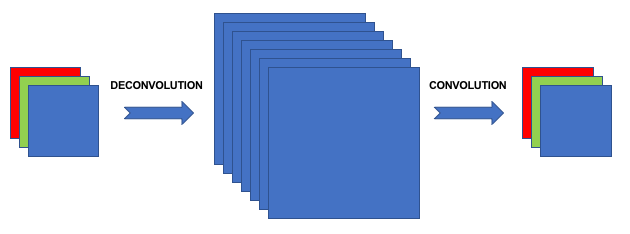

## Add Noise to Training and Testing Images

To train (and test) the denoising autoencoder we need noised images. We will produce a type of noise known as pepper. It basically mean that some of the pixels, more specifically their colour components, will be set randomly to zero. The effect is that there will be random black dots all over the place.

In [ ]:
def addRandomNoiseToSingleImage(img, noiseLevel):
    imageDimensions = img.shape
    noise = numpy.random.rand(imageDimensions[0], imageDimensions[1], imageDimensions[2])
    noiseIter = numpy.nditer([noise, None])
    for i, out in noiseIter:
        if i > noiseLevel:
            out[...] = 1
        else:
            out[...] = 0
    imageMask = noiseIter.operands[1]
    return(img * imageMask)

def addRandomNoiseToAllImages(allImages, noiseLevel):
    return(list(map(lambda img : addRandomNoiseToSingleImage(img, noiseLevel), allImages)))

noisedTrainingImages = addRandomNoiseToAllImages(trainingImages, 0.05)
noisedTestingImages = addRandomNoiseToAllImages(testingImages, 0.05)
           
numImages = len(trainingImages[:5])
plt.figure(figsize=(5, 2.5 * numImages))
for imgID in range(numImages):
    plt.subplot(numImages+1, 2, imgID * 2 + 1)
    plt.imshow(trainingImages[imgID])

    plt.subplot(numImages+1, 2, imgID * 2 + 2)
    plt.imshow(noisedTrainingImages[imgID])
plt.show()

numImages = len(testingImages[:5])
plt.figure(figsize=(5, 2.5 * numImages))
for imgID in range(numImages):
    plt.subplot(numImages+1, 2, imgID * 2 + 1)
    plt.imshow(testingImages[imgID])

    plt.subplot(numImages+1, 2, imgID * 2 + 2)
    plt.imshow(noisedTestingImages[imgID])
plt.show()

In [ ]:
def randomShuffleImages(inputImages, noisedInputImages):
    idx = (random.sample(range(len(inputImages)), len(inputImages)))
    inputImages = list(map(inputImages.__getitem__, idx))
    noisedInputImages = list(map(noisedInputImages.__getitem__, idx))
    return(inputImages, noisedInputImages)

### Define Network and Loss Function

In [ ]:
tf.reset_default_graph()
noisedInputLayer = tf.placeholder(tf.float32, (None, 256, 256, 3))
decovLayer1 = tf.contrib.layers.conv2d_transpose(inputs = noisedInputLayer,
                                     num_outputs = 32,
                                     kernel_size = 5,
                                     stride = 2,
                                     padding = "SAME")
# codeLayer = tf.contrib.layers.conv2d_transpose(inputs = decovLayer1,
#                                                num_outputs = 16,
#                                                kernel_size = 5,
#                                                stride = 2, 
#                                                padding = "SAME")
# covLayer1 = tf.contrib.layers.conv2d(inputs = codeLayer,
#                                      num_outputs = 32,
#                                      kernel_size = 5,
#                                      stride = 2,
#                                      padding = "SAME")
outputLayer = tf.contrib.layers.conv2d(inputs = decovLayer1,
                                     num_outputs = 3,
                                     kernel_size = 5,
                                     stride = 2,
                                     padding = "SAME")

#Print out layer shapes - for validation
print(inputLayer.shape)
print(decovLayer1.shape)
#print(codeLayer.shape)
#print(covLayer1.shape)
print(outputLayer.shape)

In [ ]:
# calculate the loss and optimize the network
originalInputImage = tf.placeholder(tf.float32, (None, 256, 256, 3))
lossFunction = tf.reduce_mean(tf.square(outputLayer - originalInputImage))  # calaculate the mean square error loss
optimisation = tf.train.AdamOptimizer(learning_rate=0.001).minimize(lossFunction)

# initialize the network
init = tf.global_variables_initializer()

In [ ]:
session = tf.Session()
session.run(init)

for epochID in range(100):
    epochTrainingImages, epochNoisedTrainingImages = randomShuffleImages(trainingImages, noisedTrainingImages)
    
    batchLen = len(epochTrainingImages) // 10
    print("Running epoch {}".format(epochID), end="")
    for batchID in range(batchLen):
        batchImages       = epochTrainingImages[batchID * batchLen : min((batchID+1) * batchLen, len(epochTrainingImages))]
        batchNoisedImages = epochNoisedTrainingImages[batchID * batchLen : min((batchID+1) * batchLen, len(epochNoisedTrainingImages))]
        if len(batchImages) == 0:
            continue
        _, trainLoss = session.run([optimisation, lossFunction], feed_dict = {noisedInputLayer: batchNoisedImages, originalInputImage: batchImages})
        print(".", end="")
    testLoss = session.run([lossFunction], feed_dict = {noisedInputLayer: noisedTestingImages, originalInputImage: testingImages})
    print(" loss on testing was {}".format(testLoss))

In [ ]:
outputTstImgs = session.run([outputLayer], feed_dict={noisedInputLayer: noisedTestingImages, originalInputImage: testingImages})[0]
outputTstImgs = backScaleColoursInImages(outputTstImgs)
inputTstImgs = backScaleColoursInImages(noisedTestingImages)

plt.figure(figsize=(5, 2.5 * len(inputTstImgs)))
for imgID in range(len(outputTstImgs)):
    plt.subplot(len(outputTstImgs)+1, 2, imgID * 2 + 1)
    plt.imshow(inputTstImgs[imgID])

    plt.subplot(len(outputTstImgs)+1, 2, imgID * 2 + 2)
    plt.imshow(outputTstImgs[imgID])
plt.show()

# Bonus Points

Today you can ge the bonus point by completing two tasks:
 1. There is a saved model in model directory for denoising autoencoder named "denoising-autoencoder", write code to load it,
 2. and experiment with generalisation properties of the autoencoder and find the amount of pepper noise where the trained encoder starts to fail repair all the noise.
 3. Bonus bonus task (for fun) - you may have noticed that some of the evaluated images have strange artifacts (typically in bright spots). We believe it is due to way the autoencoder's output is converted back to image. Explore this option and fix it.